In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [2]:
# Step 1: Define problem parameters
L = 50  # Length of domain in x and y directions
T0 = 100
Nx, Ny = L, L  # Number of grid points in x and y
alpha = 2  # Thermal diffusivity
h = 0.5206164
# print(h ** 2 / (2*alpha))
dt = 0.0125  # Time step size
nt = 1000  # Number of time steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
print(device)

cpu


In [3]:
def apply_boundary_condition(A, b):
    pass

def create_preconditioner(A):
    sparse_indices = A._indices()
    sparse_values = A._values()
    
    PC = torch.zeros(A.shape[0], device=device, dtype=dtype)
    for i in range(sparse_indices.shape[1]):
        row, col = sparse_indices[:, i]
        if row == col:  # Check if it's a diagonal element
            PC[row] = sparse_values[i] 
    
    return PC


def apply_preconditioner(PC, r, tol=1e-6, max_iter=10):
    z = (1 / PC) * r
    # z = torch.linalg.solve(PC, r)
    return z

def conjugate_gradient(A, b, M, a_tol=1e-6, r_tol=1e-6, max_iter=100):
    
    x = torch.zeros_like(b, device=device, dtype=dtype)  # Initial guess (zero vector)
    r = b - A @ x            # Initial residual
    z = apply_preconditioner(M, r)  # Preconditioned residual
    p = z                    # Initial search direction

    r_norm = torch.linalg.vector_norm(r)
    
    for i in range(max_iter):
        Ap = A @ p           # Matrix-vector product A*p
        rz_scala = torch.dot(r, z)
        alpha =  rz_scala / torch.dot(p, Ap)  # Step size
        
        # Update the solution
        x = x + alpha * p
        
        # Update residual
        r_new = r - alpha * Ap
        
        r_new_norm = torch.linalg.vector_norm(r_new)
        # print(r_new_norm / r_norm)
        
        if r_new_norm < a_tol or (r_new_norm / r_norm) < r_tol:
            print(f"Converged in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
            break
        
        # Apply the preconditioner iteratively
        z_new = apply_preconditioner(M, r_new)
        
        # Compute beta for the next search direction
        beta = torch.dot(r_new, z_new) / rz_scala
        
        # Update the search direction
        p = z_new + beta * p
        
        # Update residuals and preconditioned residuals for next iteration
        r = r_new
        z = z_new
        
    else:
        print(f"Did not converge in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
    return x

In [4]:
# Step 2: Generate grid (structured triangular mesh)
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

Y[1:L-1, 1: L-1] += np.random.rand(L-2, L-2) 
X[1:L-1, 1: L-1] -= np.random.rand(L-2, L-2)

triangulation = tri.Triangulation(X.flatten(), Y.flatten())

In [5]:
# Step 3: Initial condition
u0 = torch.zeros((L * L,)).to(device=device, dtype=dtype)
u0[30 * L: 30 * L + L] = T0

In [6]:
def shape_function_gradients():
    return torch.tensor([[-1, -1], [1, 0], [0, 1]], dtype=dtype)

def jacobian(coords):
    dN_dxi = shape_function_gradients()  # This should return shape (2, 3) for a single triangle
    
    # Assuming coords is of shape (N, 3, 2), where N is the number of triangles
    # Transpose `coords` so that it becomes (N, 2, 3) to match (2, 3) of dN_dxi
    J = torch.matmul(coords.transpose(1, 2), dN_dxi)  # Result: (N, 2, 2)
    
    return J

def assemble_matrices(triangulation, alpha):
    # Precompute vertex coordinates for all triangles
    x_coords = torch.tensor(triangulation.x, dtype=dtype)
    y_coords = torch.tensor(triangulation.y, dtype=dtype)
    vertices = torch.tensor(triangulation.triangles, dtype=torch.long)
    
    # Get the coordinates for all triangles
    coords = torch.stack([x_coords[vertices], y_coords[vertices]], dim=2)  # Shape: (N, 3, 2), where N is number of triangles
    
    # Augment with a column of ones for determinant calculation (for areas)
    coords_augmented = torch.cat([torch.ones(vertices.shape[0], 3, 1, dtype=dtype), coords], dim=2)
    ################################################################################################################
    # Calculate areas for all triangles at once
    areas = 0.5 * torch.abs(torch.linalg.det(coords_augmented))
    
    # Mass matrix for all triangles: (N, 3, 3)
    Me_batch = (areas / 12).unsqueeze(1).unsqueeze(2) * torch.eye(3, dtype=dtype).unsqueeze(0) * 2  # Shape (N, 3, 3)
    
    # Calculate the Jacobian for each triangle
    J_batch = jacobian(coords)  # Assumed to return a batch of Jacobians, shape (N, 2, 2)
    det_J_batch = torch.linalg.det(J_batch)
    inv_J_batch = torch.linalg.inv(J_batch)
    
    # Get shape function gradients in reference coordinates (dN/dxi)
    dN_dxi = shape_function_gradients()  # Assuming this is constant for all triangles, shape (3, 2)
    
    # Calculate dN/dxy for all triangles using the inverse Jacobian
    dN_dxy_batch = torch.matmul(inv_J_batch, dN_dxi.T)  # Shape (N, 2, 3)
    
    # Stiffness matrix computation
    Ke_batch = torch.zeros((vertices.shape[0], 3, 3), dtype=dtype)
    for i in range(3):
        for j in range(3):
            Ke_batch[:, i, j] = (alpha * det_J_batch * areas) * (dN_dxy_batch[:, 0, i] * dN_dxy_batch[:, 0, j] + dN_dxy_batch[:, 1, i] * dN_dxy_batch[:, 1, j])
    ################################################################################################################
    # Lists to store the indices and values of non-zero elements for K and M
    rows, cols, K_vals, M_vals = [], [], [], []
    # Collect contributions for global matrices in sparse form
    for i in range(3):
        for j in range(3):
            rows.extend(vertices[:, i].tolist())
            cols.extend(vertices[:, j].tolist())
            K_vals.extend(Ke_batch[:, i, j].tolist())
            M_vals.extend(Me_batch[:, i, j].tolist())
    
    # Create sparse tensors from the accumulated lists
    npoints = len(triangulation.x)  # Total number of points in the mesh
    K = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=K_vals,
        size=(npoints, npoints)
    )
    
    M = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=M_vals,
        size=(npoints, npoints)
    )
    
    return K, M

K, M = assemble_matrices(triangulation, alpha)
K = K.to(device=device, dtype=dtype)
M = M.to(device=device, dtype=dtype)

In [7]:
U = torch.zeros((nt, L, L)).to(device=device, dtype=dtype)
U[0,:,:] = u0.reshape((L, L))

u = u0
M_dt = M * (1 / dt)
A = M_dt + K

In [8]:
dirichlet_boundary_nodes = torch.arange(30 * L, 30 * L + L, device=device)
boundary_values = torch.ones_like(dirichlet_boundary_nodes, device=device, dtype=dtype) * T0

sparse_indices = A._indices() # apply boundary condition
sparse_values = A._values()

mask = ~torch.isin(sparse_indices[0], dirichlet_boundary_nodes) 
new_indices = sparse_indices[:, mask]
new_values = sparse_values[mask]

identity_indices = torch.stack([dirichlet_boundary_nodes, dirichlet_boundary_nodes], dim=0).to(device=device, dtype=dtype)  # Diagonal indices
identity_values = torch.ones_like(dirichlet_boundary_nodes)  # Diagonal values are set to 1.0

final_indices = torch.cat([new_indices, identity_indices], dim=1)
final_values = torch.cat([new_values, identity_values])
A = torch.sparse_coo_tensor(final_indices, final_values, A.shape)

PC = create_preconditioner(A)

In [9]:
for n in range(1, nt):
    print(f"{n}", end=" ")
    b = torch.sparse.mm(M_dt, u.unsqueeze(1)).squeeze(1)
    
    b[dirichlet_boundary_nodes] = boundary_values # apply boundary condition
    u = conjugate_gradient(A, b, PC, a_tol=1e-5, r_tol=1e-5, max_iter=100)
    
    U[n, :, :] = u.reshape((L, L))

1 Did not converge in 99 iterations tensor(False) tensor(False)
2 Converged in 39 iterations tensor(False) tensor(True)
3 Converged in 38 iterations tensor(False) tensor(True)
4 Converged in 37 iterations tensor(False) tensor(True)
5 Converged in 38 iterations tensor(False) tensor(True)
6 Converged in 38 iterations tensor(False) tensor(True)
7 Converged in 38 iterations tensor(False) tensor(True)
8 Converged in 38 iterations tensor(False) tensor(True)
9 Converged in 38 iterations tensor(False) tensor(True)
10 Converged in 38 iterations tensor(False) tensor(True)
11 Converged in 39 iterations tensor(False) tensor(True)
12 Converged in 39 iterations tensor(False) tensor(True)
13 Converged in 39 iterations tensor(False) tensor(True)
14 Converged in 39 iterations tensor(False) tensor(True)
15 Converged in 39 iterations tensor(False) tensor(True)
16 Converged in 39 iterations tensor(False) tensor(True)
17 Converged in 39 iterations tensor(False) tensor(True)
18 Converged in 39 iterations te

In [10]:
def plotheatmap(tr, u_k , k):
    plt.clf()

    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.tripcolor(tr, u_k.flatten(), cmap=plt.cm.jet, vmin=0, vmax=100, shading='gouraud')
    plt.colorbar()

In [11]:
U = U.cpu()
def animate(k):
    plotheatmap(triangulation, U[k], k)

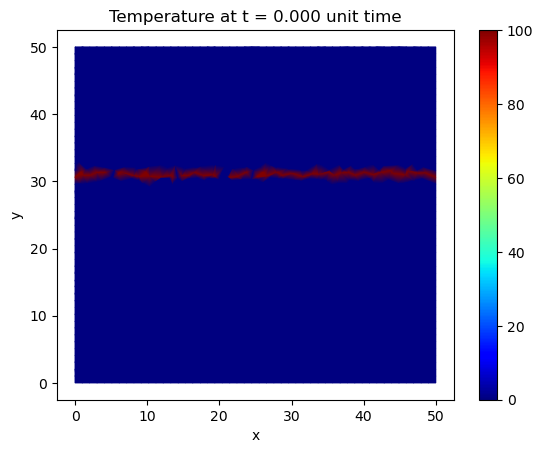

In [12]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=nt, repeat=False)
anim.save("FEM - 2D Heat Equation - PCG - Sparse - Batch.gif")